In [42]:
import os
from pathlib import Path
import string
import numpy

import pandas
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [43]:
articles_dir = Path(os.getcwd(), 'data', 'articles')
titles_dir = Path(os.getcwd(), 'data', 'titles')

In [44]:
MAX_TEXT_LENGTH = 128
MAX_SUMMARY_LENGTH = 64

# Data preprocessing (word embedding)

In [45]:
# Remove puncuation from text
def remove_punc_from_text(text):
    clean_word_list = [char for char in text if char not in string.punctuation]
    return ''.join(clean_word_list)


# select the summary and text between their defined max lens respectively
def trim_text_and_summary(df, max_text_len, max_summary_len):
    cleaned_text = numpy.array(df['text'])
    cleaned_summary = numpy.array(df['summary'])

    short_text = []
    short_summary = []

    for i in range(len(cleaned_text)):
        if len(cleaned_text[i].split()) <= max_text_len and len(
            cleaned_summary[i].split()
        ) <= max_summary_len:
            short_text.append(cleaned_text[i])
            short_summary.append(cleaned_summary[i])

    df = pandas.DataFrame({'text': short_text, 'summary': short_summary})
    return df


# TODO: remove stopwords

In [46]:
# rare word analysis
def get_rare_word_percent(tokenizer, threshold):
    # threshold: if the word's occurrence is less than this then it's rare word

    count = 0
    total_count = 0
    frequency = 0
    total_frequency = 0

    for key, value in tokenizer.word_counts.items():
        total_count += 1
        total_frequency += value
        if value < threshold:
            count += 1
            frequency += value

    return {
        'percent': round((count / total_count) * 100, 2),
        'total_coverage': round(frequency / total_frequency * 100, 2),
        'count': count,
        'total_count': total_count
    }

In [47]:
# Collect articles content and summary to dataframe
dataset = []
list_article_files = os.listdir(articles_dir)
for filename in list_article_files:
    with open(Path(articles_dir, filename), 'r') as article_file:
        text = article_file.read()
        with open(Path(titles_dir, filename), 'r') as title_file:
            summary = title_file.read()
            dataset.append({ 'summary': summary, 'text': text })

dataset_df = pandas.DataFrame.from_records(dataset)

# Normalize train data
dataset_df.summary = [f'_START_{remove_punc_from_text(summary.lower())}_END_' for summary in dataset_df['summary']]
dataset_df.text = [remove_punc_from_text(text.lower()) for text in dataset_df['text']]

# Add tokens
start_token = 'sostok'
end_token = 'eostok'
dataset_df.summary = dataset_df.summary.apply(lambda x: f'{start_token} {x} {end_token}')

# Trim text and summary
dataset_df = trim_text_and_summary(dataset_df, MAX_TEXT_LENGTH, MAX_SUMMARY_LENGTH)
print(f'Dataset size: {len(dataset_df)}')

# Split datasets to training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    numpy.array(dataset_df['text']),
    numpy.array(dataset_df['summary']),
    test_size=0.1,
    random_state=1,
    shuffle=True
)

# Tokenizing text of x sets
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))
x_tokens_data = get_rare_word_percent(x_tokenizer, 4)
x_tokenizer = Tokenizer(num_words=x_tokens_data['total_count'] - x_tokens_data['count'])
x_tokenizer.fit_on_texts(list(x_train))
x_train_sequence = x_tokenizer.texts_to_sequences(x_train)
x_val_sequence = x_tokenizer.texts_to_sequences(x_val)
x_train_padded = pad_sequences(x_train_sequence, maxlen=MAX_TEXT_LENGTH, padding='post')
x_val_padded = pad_sequences(x_val_sequence, maxlen=MAX_TEXT_LENGTH, padding='post')
x_vocab_size = len(x_tokenizer.word_index) + 1

# Tokenizing text of y sets
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))
y_tokens_data = get_rare_word_percent(y_tokenizer, 6)
y_tokenizer = Tokenizer(num_words=y_tokens_data['total_count'] - y_tokens_data['count'])
y_tokenizer.fit_on_texts(list(y_train))
y_train_sequence = x_tokenizer.texts_to_sequences(y_train)
y_val_sequence = x_tokenizer.texts_to_sequences(y_val)
y_train_padded = pad_sequences(y_train_sequence, maxlen=MAX_SUMMARY_LENGTH, padding='post')
y_val_padded = pad_sequences(y_val_sequence, maxlen=MAX_SUMMARY_LENGTH, padding='post')
y_vocab_size = len(y_tokenizer.word_index) + 1

print(f'[Vocab size] x: {x_vocab_size} <-> y: {y_vocab_size}')
print(x_tokens_data)
print(y_tokens_data)

Dataset size: 549
[Vocab size] x: 1912 <-> y: 899
{'percent': 67.5, 'total_coverage': 6.09, 'count': 1290, 'total_count': 1911}
{'percent': 88.53, 'total_coverage': 19.32, 'count': 795, 'total_count': 898}


In [ ]:
# removing summary which only has sostok & eostok
def remove_indexes(summary_array):
    remove_indexes = []
    for i in range(len(summary_array)):
        count = 0
        for j in summary_array[i]:
            if j != 0:
                count += 1
        if count == 2:
            remove_indexes.append(i)
    return remove_indexes


remove_train_indexes = remove_indexes(y_train_padded)
remove_val_indexes = remove_indexes(y_val_padded)

y_train_padded = numpy.delete(y_train_padded, remove_train_indexes, axis=0)
x_train_padded = numpy.delete(x_train_padded, remove_train_indexes, axis=0)

y_val_padded = numpy.delete(y_val_padded, remove_val_indexes, axis=0)
x_val_padded = numpy.delete(x_val_padded, remove_val_indexes, axis=0)

# Modeling

In [48]:
LATENT_DIM = 240
EMBEDDING_DIM = 300
NUM_EPOCHS = 50

GLOVE_FILE_PATH = Path(os.getcwd(), 'glove', 'glove.6B.300d.txt')

In [49]:
def get_embedding_matrix (tokenizer, embedding_dim, vocab_size):
    word_index = tokenizer.word_index
    vocab = list(word_index.keys())

    embeddings_index = {}
    with open(GLOVE_FILE_PATH) as file:
        for line in file:
            word, coefs = line.split(maxsplit=1)
            coefs = numpy.fromstring(coefs, 'f', sep=' ')
            embeddings_index[word] = coefs
    
    print(f'Found {len(embeddings_index)} word vector.')

    num_tokens = len(vocab) + 2 if not vocab_size else vocab_size
    hits = 0
    misses = 0

    # Prepare embedding matrix
    embedding_matrix = numpy.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1

    print(f'Converted {hits} words ({misses} misses)')

    return embedding_matrix


x_embedding_matrix = get_embedding_matrix(x_tokenizer, EMBEDDING_DIM, x_vocab_size)
y_embedding_matrix = get_embedding_matrix(y_tokenizer, EMBEDDING_DIM, y_vocab_size)

print(x_embedding_matrix.shape)
print(y_embedding_matrix.shape)

Found 400000 word vector.
Converted 1034 words (877 misses)
Found 400000 word vector.
Converted 521 words (377 misses)
(1912, 300)
(899, 300)


In [50]:
def build_seq2seq_model(embedding_dim, latent_dim, max_text_len, x_vocab_size, y_vocab_size, x_embedding_matrix, y_embedding_matrix):
    # Encoder
    # ====================
    encoder_input = Input(shape=(max_text_len, ))

    # encoder embedding layer
    encoder_embedding = Embedding(
        x_vocab_size,
        embedding_dim,
        embeddings_initializer=tensorflow.keras.initializers.Constant(x_embedding_matrix),
        trainable=False
    )(encoder_input)

    # encoder lstm 1
    encoder_lstm1 = LSTM(
        latent_dim,
        return_sequences=True,
        return_state=True,
        dropout=0.4,
        recurrent_dropout=0.4
    )
    encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_embedding)

    # encoder lstm 2
    encoder_lstm2 = LSTM(
        latent_dim,
        return_sequences=True,
        return_state=True,
        dropout=0.4,
        recurrent_dropout=0.4
    )
    encoder_output, *encoder_final_states = encoder_lstm2(encoder_output1)
    # ====================

    # Decoder
    # ====================
    # Set up the decoder, using `encoder_states` as initial state.
    decoder_input = Input(shape=(None, ))

    # decoder embedding layer
    decoder_embedding_layer = Embedding(
        y_vocab_size,
        embedding_dim,
        embeddings_initializer=tensorflow.keras.initializers.Constant(y_embedding_matrix),
        trainable=True
    )
    decoder_embedding = decoder_embedding_layer(decoder_input)

    # decoder lstm 1
    decoder_lstm = LSTM(
        latent_dim,
        return_sequences=True,
        return_state=True,
        dropout=0.4,
        recurrent_dropout=0.4
    )
    decoder_output, *decoder_final_states = decoder_lstm(
        decoder_embedding, initial_state=encoder_final_states
    )

    # dense layer
    decoder_dense = TimeDistributed(
        Dense(y_vocab_size, activation='softmax')
    )
    decoder_output = decoder_dense(decoder_output)

    # Model
    # ====================
    model = Model([encoder_input, decoder_input], decoder_output)
    model.summary()

    optimizer = tensorflow.keras.optimizers.RMSprop(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return {
        'model': model,
        'inputs': {
            'encoder': encoder_input,
            'decoder': decoder_input
        },
        'outputs': {
            'encoder': encoder_output,
            'decoder': decoder_output
        },
        'states': {
            'encoder': encoder_final_states,
            'decoder': decoder_final_states
        },
        'layers': {
            'decoder': {
                'embedding': decoder_embedding_layer,
                'last_decoder_lstm': decoder_lstm,
                'dense': decoder_dense
            }
        }
    }


In [51]:
seq2seq = build_seq2seq_model(
    EMBEDDING_DIM, LATENT_DIM, MAX_TEXT_LENGTH,
    x_vocab_size=x_vocab_size, y_vocab_size=y_vocab_size,
    x_embedding_matrix=x_embedding_matrix, y_embedding_matrix=y_embedding_matrix
)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 128, 300)     573600      ['input_11[0][0]']               
                                                                                                  
 input_12 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 lstm_6 (LSTM)                  [(None, 128, 240),   519360      ['embedding_4[0][0]']            
                                 (None, 240),                                               

In [52]:
callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.000001, verbose=1),
]

model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

history = model.fit(
    [x_train_padded, y_train_padded[:, :-1]],
    y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1], 1)[:, 1:],
    epochs=NUM_EPOCHS,
    batch_size=128,
    callbacks=callbacks,
    validation_data=(
        [x_val_padded, y_val_padded[:, :-1]],
        y_val_padded.reshape(y_val_padded.shape[0], y_val_padded.shape[1], 1)[:, 1:]
    )
)

Epoch 1/50
4/4 [==============================] - 9s 2s/step - loss: 5.0519 - accuracy: 0.6635 - val_loss: 0.9719 - val_accuracy: 0.8921 - lr: 0.0010
Epoch 2/50
4/4 [==============================] - 8s 2s/step - loss: 0.8046 - accuracy: 0.8902 - val_loss: 0.6288 - val_accuracy: 0.8975 - lr: 0.0010
Epoch 3/50
4/4 [==============================] - 9s 2s/step - loss: 0.6268 - accuracy: 0.9008 - val_loss: 0.5557 - val_accuracy: 0.9140 - lr: 0.0010
Epoch 4/50
4/4 [==============================] - 9s 2s/step - loss: 0.5588 - accuracy: 0.9156 - val_loss: 0.5296 - val_accuracy: 0.9209 - lr: 0.0010
Epoch 5/50
4/4 [==============================] - 8s 2s/step - loss: 0.5281 - accuracy: 0.9226 - val_loss: 0.4905 - val_accuracy: 0.9299 - lr: 0.0010
Epoch 6/50
4/4 [==============================] - 8s 2s/step - loss: 0.5023 - accuracy: 0.9264 - val_loss: 0.4746 - val_accuracy: 0.9302 - lr: 0.0010
Epoch 7/50
4/4 [==============================] - 8s 2s/step - loss: 0.4701 - accuracy: 0.9291 - val

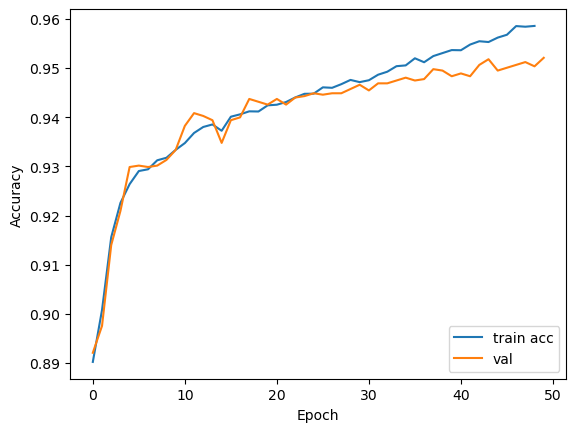

In [53]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

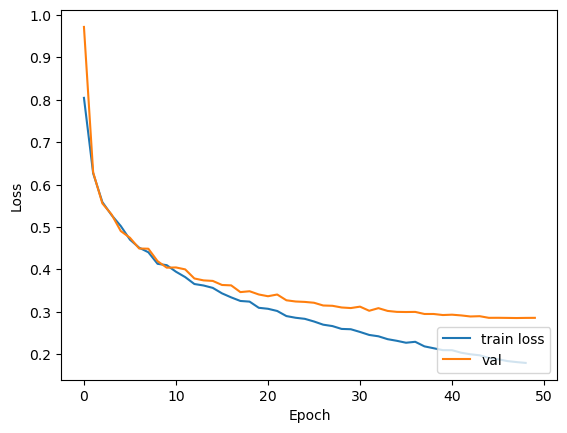

In [54]:
# Loss
plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

# Inference

In [55]:
def build_seq2seq_model_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
):
    # Encode the input sequence to get the feature vector
    encoder_model = Model(
        inputs=encoder_input, outputs=[encoder_output] + encoder_final_states
    )

    # Decoder setup
    # Below tensors will hold the states of the previous time step
    decoder_state_input_h = Input(shape=(latent_dim, ))
    decoder_state_input_c = Input(shape=(latent_dim, ))
    decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

    # Get the embeddings of the decoder sequence
    decoder_embedding = decoder_embedding_layer(decoder_input)

    # To predict the next word in the sequence, set the initial
    # states to the states from the previous time step
    decoder_output, *decoder_states = last_decoder_lstm(
        decoder_embedding,
        initial_state=[decoder_state_input_h, decoder_state_input_c]
    )

    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_output = decoder_dense(decoder_output)

    # Final decoder model
    decoder_model = Model(
        [decoder_input] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c], 
        [decoder_output] + decoder_states
    )

    return (encoder_model, decoder_model)

In [56]:
encoder_model, decoder_model = build_seq2seq_model_inference(
    MAX_TEXT_LENGTH, LATENT_DIM, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
)

# Summarization

In [57]:
# Build the dictionary to convert the index to word for target and source vocabulary:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [88]:
def decode_sequence_seq2seq_model(
    input_sequence, encoder_model, decoder_model
):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_sequence)

    # Generate empty target sequence of length 1.
    target_seq = numpy.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index[start_token]

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + [e_out, e_h, e_c]
        )

        # Sample a token
        sampled_token_index = numpy.argmax(output_tokens[0, -1, :])

        try:
            sampled_token = reverse_target_word_index[sampled_token_index]
        except:
            stop_condition = True

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == end_token) or (len(decoded_sentence.split()) >= (MAX_SUMMARY_LENGTH - 1)):
            stop_condition = True

        if sampled_token != end_token and sampled_token != start_token:
            decoded_sentence += ' ' + sampled_token

        # Update the target sequence (of length 1).
        target_seq = numpy.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [74]:
def seq2text(input_sequence):
    new_string = ''
    for i in input_sequence:
        if i != 0:
            new_string = new_string + reverse_source_word_index[i] + ' '
    return new_string

In [73]:
def seq2summary(input_sequence):
    new_string = ''
    for i in input_sequence:
        if (
            (i != 0 and i != target_word_index[start_token]) and
            (i != target_word_index[end_token])
        ):
            new_string = new_string + reverse_target_word_index[i] + ' '
    return new_string

# Test

In [96]:
# Testing on training data
for i in range(1, 15):
    print(f"#{i} => News: ", seq2text(x_train_padded[i]))
    print("Original summary: ", seq2summary(y_train_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_seq2seq_model(
            x_train_padded[i].reshape(1, MAX_TEXT_LENGTH), encoder_model,
            decoder_model
        )
    )
    print()

#1 => News:  danh sách các mã cổ phiếu tăng và giảm mạnh nhất những phiên gần đây theo số liệu thống kê của vietstock 2 phiên 3 phiên 4 phiên 5 phiên giao dịch nhiều danh sách các mã tăng giảm giá nhiều nhất xét đến khối lượng giao dịch trên 10000 đơn vị đức đỗ fili 
Original summary:  niêm đáng doanh 2013 0711 ngoại 
Predicted summary:   đáng doanh 2013 0711 ngoại

#2 => News:  trong thời gian từ bà nguyễn thị minh thư ông nam bình phó chủ tịch hđqt ctcp dược bị tế bình định hose đã mua cp trong tổng số 1 triệu cp đã đăng ký do thị trường không thuận lợi với giá trung bình giai đoạn trên là đồngcp ước tính bà thư đã chi hơn tỷ đồng để thực hiện giao dịch giá cổ phiếu lao dốc trong các phiên giao dịch gần đây từ đỉnh gần nhất đồngcp phiên giá cổ phiếu đáy đồngcp 2006 kết phiên 2106 thị giá chốt ở mức đồngcp giảm hơn 11 so với mức đỉnh nêu trên đức đỗ fili 
Original summary:  phí upcom 9 hơn điện năm đáng doanh hủy chi 
Predicted summary:   đáng doanh 2013 0711 ngoại

#3 => News:  
Orig